In [1]:
import os
import glob
import numpy as np
import tensorflow as tf 
import cv2

from PIL import Image
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'main')
SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'gan_segmented')
AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'gan_augmented_segmented')

## Preprocess

In [3]:
def dilate(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    dilation = cv2.dilate(image, kernel, iterations=1)
    return dilation

def erode(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    return erosion

def gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2):
    blur = cv2.GaussianBlur(image, kernel, 0)
    thresholded_image = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize=block_size, C=C
    )
    return thresholded_image

def combine_boxes(box1, box2):
    """Combine two overlapping boxes into a single box."""
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[0] + box1[2], box2[0] + box2[2])
    y2 = max(box1[1] + box1[3], box2[1] + box2[3])

    # Return combined box
    return (x1, y1, x2 - x1, y2 - y1)

def boxes_overlap(box1, box2):
    """Check if two boxes overlap."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def non_max_suppression(boxes):
    """Combine overlapping boxes."""
    if len(boxes) == 0:
        return []

    boxes = sorted(boxes, key=lambda box: box[0])  # Sort by x-coordinate
    combined_boxes = []

    while boxes:
        current_box = boxes.pop(0)
        to_merge = []

        # Check for boxes that overlap with current_box and merge them
        for box in boxes:
            if boxes_overlap(current_box, box):  # Check if they overlap
                to_merge.append(box)

        # Combine all overlapping boxes into one
        for box in to_merge:
            current_box = combine_boxes(current_box, box)
            boxes.remove(box)

        combined_boxes.append(current_box)

    return combined_boxes

def extract_contours(image, min_height=10):
    """Extract contours and return bounding boxes."""
    inverted_image = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes and filter by height
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.boundingRect(contour)[3] > min_height]

    return bounding_boxes

def segment_characters(image):
    """Segment the CAPTCHA image into individual characters using NMS."""
    # Step 1: Extract bounding boxes from contours
    bounding_boxes = extract_contours(image)

    # Step 2: Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
    nms_boxes = non_max_suppression(bounding_boxes)

    # Step 3: Create tuples of (x_coordinate, box, char_image) to maintain correct order
    char_info = []
    for box in nms_boxes:
        x, y, w, h = box
        char_image = image[y:y+h, x:x+w]
        char_info.append((x, box, char_image))

    # Step 4: Sort by x-coordinate and extract ordered images
    char_info.sort(key=lambda x: x[0])  # Sort by x-coordinate
    nms_boxes = [info[1] for info in char_info]  # Keep boxes in same order
    char_images = [info[2] for info in char_info]  # Keep images in same order

    return nms_boxes, char_images # nms_boxes is used for plotting

In [ ]:
def preprocess_image(image):
    image = cv2.bitwise_not(image)
    image = erode(image, kernel_size=(2, 2))
    image = cv2.bitwise_not(image)
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))
    return image

def process_and_save_images(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Keep track of how many captchas were skipped
    skipped_count = 0

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if not filename.endswith('.png'):
            continue

        # Extract the true label from the filename
        base_name = filename.split('-')[0]

        # Load the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply preprocessing steps
        image = preprocess_image(image)

        # Segment characters
        _, char_images = segment_characters(image)

        # Validate the number of segmented parts
        if len(char_images) != len(base_name):
            print(f"Skipping {filename}: Expected {len(base_name)} parts, got {len(char_images)}.")
            skipped_count += 1
            continue  # Skip saving this image

        # Save each segmented character follow the naming convention <label_str>-<char>.png
        for idx, char_img in enumerate(char_images):
            char_label = base_name[idx]
            save_name = f"{base_name}-{char_label}.png"
            save_path = os.path.join(output_dir, save_name)

            # Save the segmented character
            cv2.imwrite(save_path, char_img)

    print(f"Processing complete! Segmented characters are saved in {output_dir}")
    print(f"Total skipped: {skipped_count}")


process_and_save_images(TRAIN_DATASET_PATH, SEGMENTED_TRAIN_DATASET_PATH)

Skipping 00fh-0.png: Expected 4 parts, got 0.
Skipping 010b-0.png: Expected 4 parts, got 6.
Skipping 010ud-0.png: Expected 5 parts, got 1.
Skipping 02cc-0.png: Expected 4 parts, got 2.
Skipping 06rh65-0.png: Expected 6 parts, got 5.
Skipping 06xg-0.png: Expected 4 parts, got 5.
Skipping 06yx8nkv-0.png: Expected 8 parts, got 7.
Skipping 07smvpl-0.png: Expected 7 parts, got 8.
Skipping 08mse1o-0.png: Expected 7 parts, got 9.
Skipping 08xj75-0.png: Expected 6 parts, got 7.
Skipping 0al4pl-0.png: Expected 6 parts, got 7.
Skipping 0axhfa-0.png: Expected 6 parts, got 4.
Skipping 0bcjvo4p-0.png: Expected 8 parts, got 9.
Skipping 0chnm34-0.png: Expected 7 parts, got 3.
Skipping 0cr6-0.png: Expected 4 parts, got 2.
Skipping 0d0vp1-0.png: Expected 6 parts, got 5.
Skipping 0duo1r-0.png: Expected 6 parts, got 2.
Skipping 0dw9b7hd-0.png: Expected 8 parts, got 7.
Skipping 0favtnx-0.png: Expected 7 parts, got 6.
Skipping 0fm4a3rx-0.png: Expected 8 parts, got 12.
Skipping 0gzwaq8-0.png: Expected 7 par

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_and_save_images(input_dir, output_dir, augment_count=3):
    """Augment images from `input_dir` and save them with proper naming to `output_dir`."""
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # Define a more controlled data augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=10,          # Small rotation for better quality
        width_shift_range=0.05,     # Slight horizontal shift
        height_shift_range=0.05,    # Slight vertical shift
        shear_range=0.1,            # Mild shearing
        zoom_range=0.1,             # Mild zoom
        fill_mode='nearest'         # Avoid introducing artifacts
    )

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            # Load the original image
            image_path = os.path.join(input_dir, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Expand dimensions for augmentation
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            img = np.expand_dims(img, axis=0)   # Add batch dimension

            # Extract the base filename without extension (e.g., 'abc-o')
            base_name = filename.split('.')[0]

            # Generate and save augmented images
            for i, batch in enumerate(datagen.flow(img, batch_size=1)):
                # Save each augmented image with proper naming
                augmented_filename = f"{base_name}-{i + 1}.png"
                augmented_path = os.path.join(output_dir, augmented_filename)

                # Save the augmented image
                cv2.imwrite(augmented_path, batch[0].squeeze().astype(np.uint8))

                # Stop after generating `augment_count` images per original image
                if i + 1 >= augment_count:
                    break

    print(f"Augmentation complete! Augmented images saved in {output_dir}")

augment_and_save_images(SEGMENTED_TRAIN_DATASET_PATH, AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH)


Augmentation complete! Augmented images saved in d:\cs4243\data\gan_augmented_segmented


In [3]:
# Define character set (e.g., 0-9, a-z)
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHAR_SET)}

def load_dataset(data_dir):
    images = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            # Extract the character from the filename (e.g., 'o' from 'oq1j-o.png')
            char_label = filename.split('-')[1][0]

            if char_label in CHAR_TO_IDX:
                # Load the image in grayscale
                image_path = os.path.join(data_dir, filename)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize to 28x28 (if needed)
                img = cv2.resize(img, (28, 28))
                img = img / 255.0  # Normalize pixel values to [0, 1]

                # Store the image and label
                images.append(img)
                labels.append(CHAR_TO_IDX[char_label])

    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 28, 28, 1)  # Add channel dimension
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_dataset(SEGMENTED_TRAIN_DATASET_PATH)
print(f"Loaded {len(images)} images with {len(set(labels))} unique labels.")

Loaded 45031 images with 36 unique labels.


## Train

In [13]:
## invert the images
# inv_images = 1 - images

import pickle
# pickle.dump(inv_images, open('loaded_images.pkl', 'wb'))
inv_images = pickle.load(open('loaded_images.pkl', 'rb'))

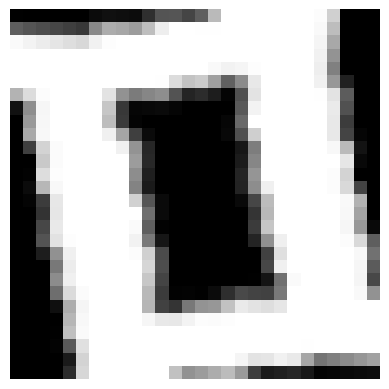

In [10]:
## plot 1 sample
import matplotlib.pyplot as plt
plt.imshow(inv_images[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [5]:
inv_images.shape

(135093, 28, 28, 1)

In [15]:
print(inv_images)

[[[[0.00392157]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.36862745]
   [0.32941176]
   [0.30196078]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.98039216]
   [0.95294118]
   [0.9254902 ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.54509804]
   [0.58823529]
   [0.63137255]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.03529412]
   [0.04313725]
   [0.05098039]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

(135093, 28, 28, 1)


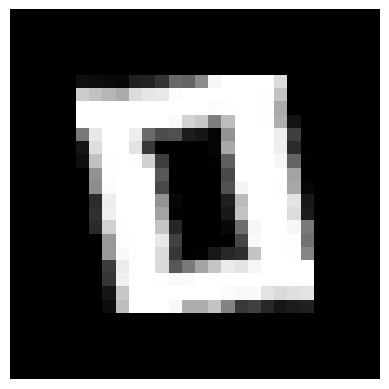

In [14]:
## padding the images with background then resize to make edge detection more obvious between different characters
def pad_image(image, pad_size=8):
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'constant', constant_values=0)
    padded_image = cv2.resize(padded_image, (28, 28))
    padded_image = padded_image[:, :, np.newaxis]
    return padded_image

inv_images = np.array([pad_image(image) for image in inv_images])
print(inv_images.shape)
plt.imshow(inv_images[0], cmap='gray')
plt.axis('off')
plt.show() 

(135093, 28, 28, 1)


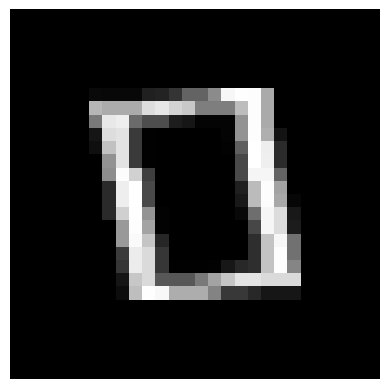

In [15]:
def reduce_edge_thickness(image):
    img = erode(image)
    img = img[:, :, np.newaxis]
    return img

inv_images = np.array([reduce_edge_thickness(image) for image in inv_images])
print(inv_images.shape)
plt.imshow(inv_images[0], cmap='gray')
plt.axis('off')
plt.show() 

In [16]:
train_images = inv_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [17]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [60]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


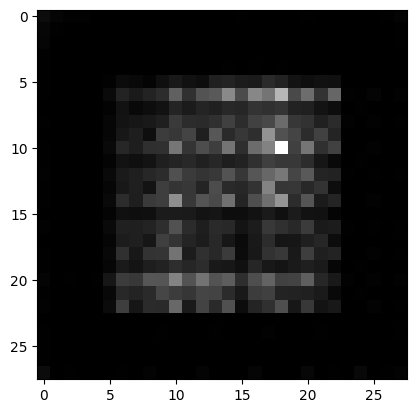

In [19]:
import matplotlib.pyplot as plt
# generator = make_generator_model()

## load the generator model
generator = tf.keras.models.load_model('generator.keras')
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [62]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, LeakyReLU
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model


In [21]:
# discriminator = make_discriminator_model()
discriminator = tf.keras.models.load_model('discriminator.keras')
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.01156119]], shape=(1, 1), dtype=float32)


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) * 0.9
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) * 0.1
    total_loss = real_loss + fake_loss
    return total_loss


In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [29]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [30]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    print(f'gen_loss: {gen_loss}, disc_loss: {disc_loss}')
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [35]:
import time
import matplotlib.pyplot as plt
from IPython import display

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(150 + epoch))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        print("Epoch: ", epoch)
        start = time.time()

        batch_num = 1
        for image_batch in dataset:
            batch_num += 1

            if batch_num % 100 == 0:
                print(f"Batch: {batch_num}/{len(dataset)}")
            train_step(image_batch)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        # Produce images for the GIF as you go
        # display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = f"{checkpoint_prefix}_2")

    # Generate after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


Epoch:  0
gen_loss: Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32), disc_loss: Tensor("add:0", shape=(), dtype=float32)
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
gen_loss: Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32), disc_loss: Tensor("add:0", shape=(), dtype=float32)
Time for epoch 1 is 289.13760781288147 sec


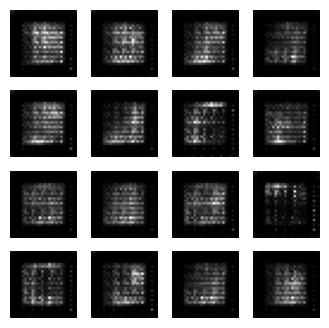

Epoch:  1
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 2 is 292.35370898246765 sec


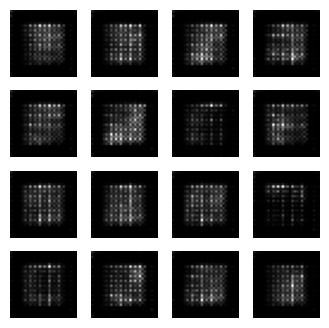

Epoch:  2
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 3 is 265.5717771053314 sec


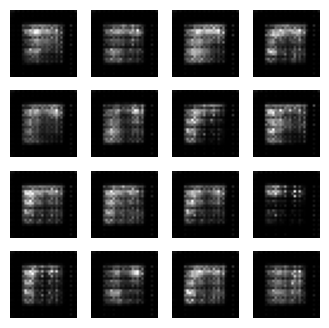

Epoch:  3
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 4 is 268.2946927547455 sec


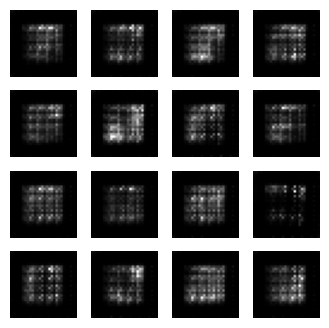

Epoch:  4
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 5 is 272.76631259918213 sec


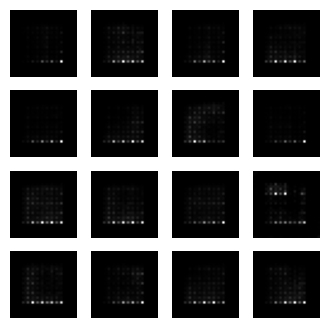

Epoch:  5
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 6 is 246.20883131027222 sec


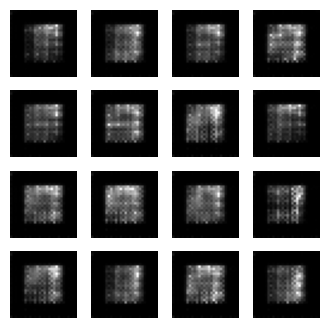

Epoch:  6
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 7 is 245.88140892982483 sec


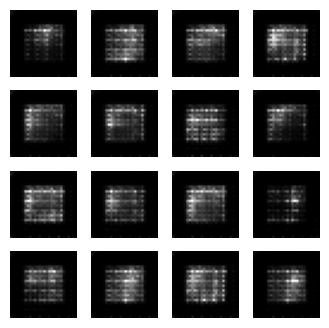

Epoch:  7
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 8 is 246.72575783729553 sec


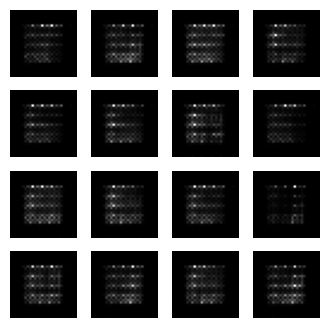

Epoch:  8
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 9 is 246.74416613578796 sec


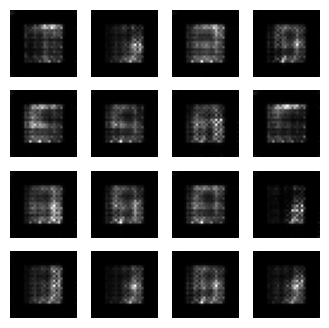

Epoch:  9
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 10 is 246.89532113075256 sec


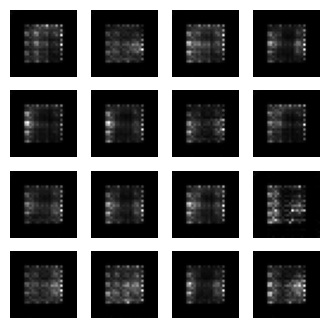

Epoch:  10
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 11 is 246.61046743392944 sec


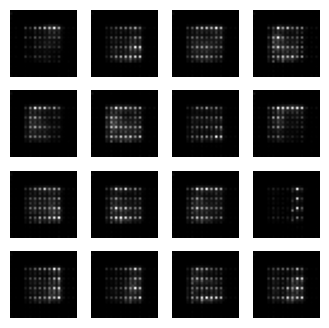

Epoch:  11
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 12 is 247.23995637893677 sec


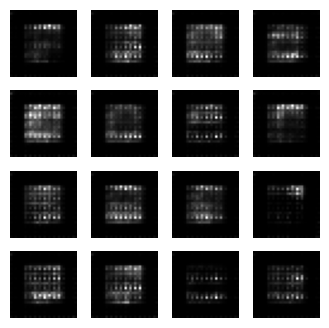

Epoch:  12
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 13 is 246.29244303703308 sec


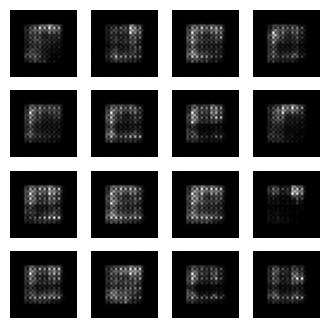

Epoch:  13
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 14 is 250.01077032089233 sec


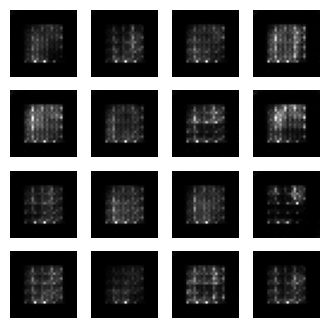

Epoch:  14
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 15 is 246.48877811431885 sec


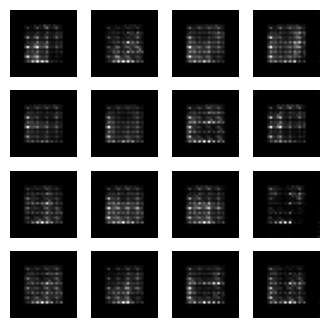

Epoch:  15
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 16 is 248.35809445381165 sec


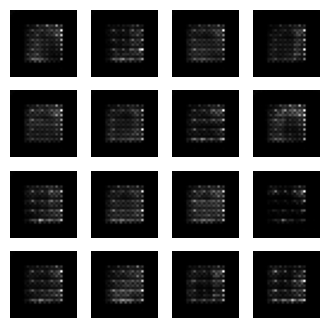

Epoch:  16
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 17 is 247.58744549751282 sec


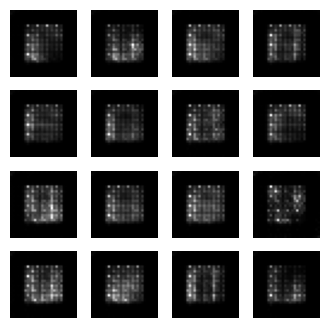

Epoch:  17
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 18 is 246.24143815040588 sec


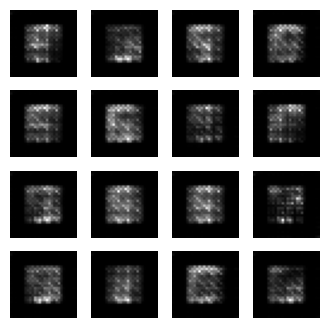

Epoch:  18
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 19 is 246.5522096157074 sec


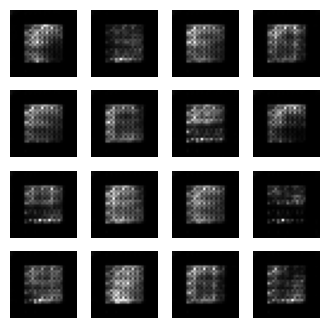

Epoch:  19
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 20 is 246.84328508377075 sec


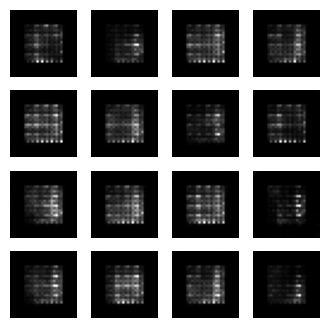

Epoch:  20
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 21 is 246.64682364463806 sec


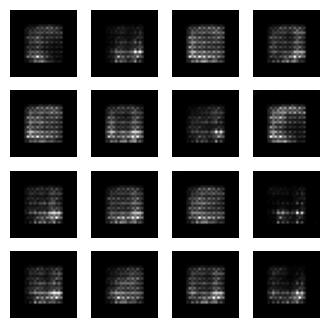

Epoch:  21
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 22 is 246.39548516273499 sec


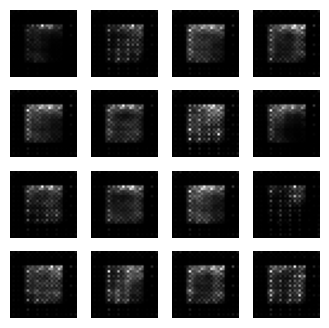

Epoch:  22
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 23 is 247.4580476284027 sec


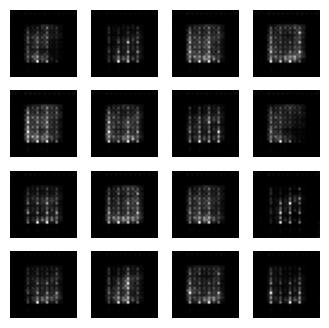

Epoch:  23
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 24 is 246.8745493888855 sec


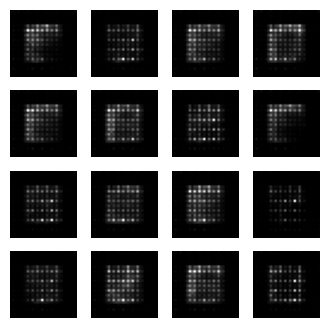

Epoch:  24
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 25 is 247.07491850852966 sec


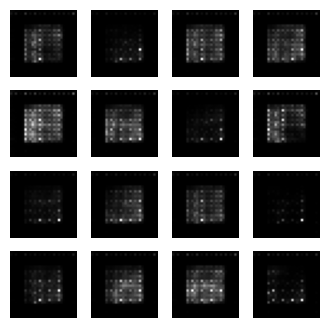

Epoch:  25
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 26 is 246.12832713127136 sec


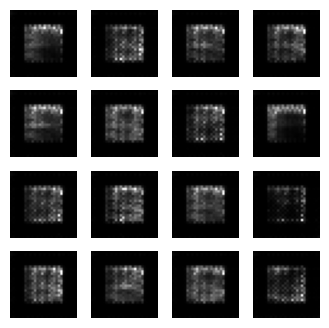

Epoch:  26
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 27 is 246.61891508102417 sec


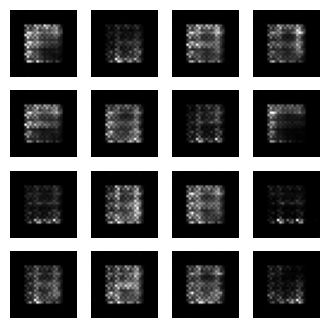

Epoch:  27
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 28 is 246.5401782989502 sec


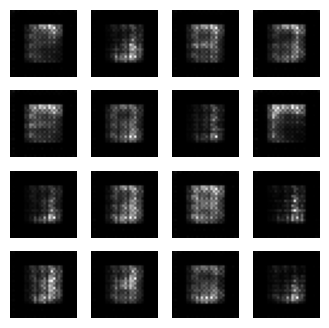

Epoch:  28
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 29 is 246.87584447860718 sec


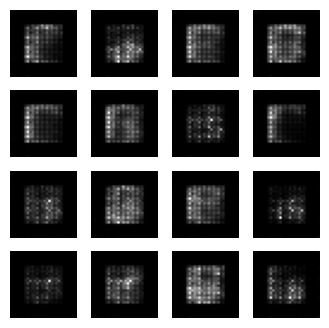

Epoch:  29
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 30 is 246.72300481796265 sec


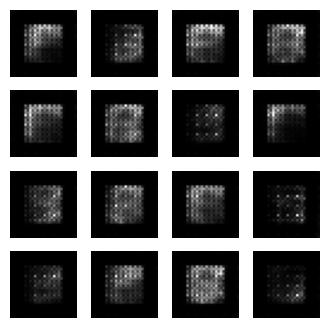

Epoch:  30
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 31 is 247.1096911430359 sec


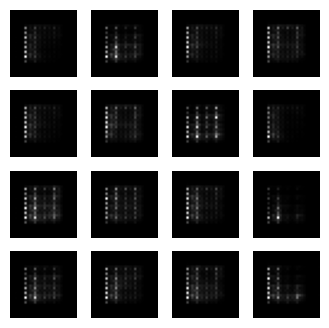

Epoch:  31
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 32 is 247.85991525650024 sec


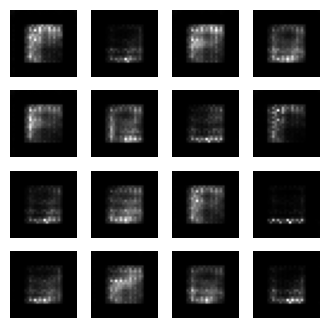

Epoch:  32
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 33 is 246.68464183807373 sec


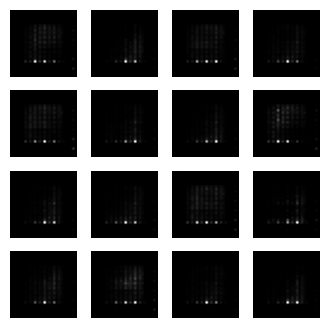

Epoch:  33
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 34 is 247.62483620643616 sec


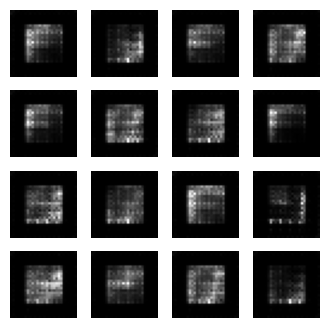

Epoch:  34
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 35 is 246.5246500968933 sec


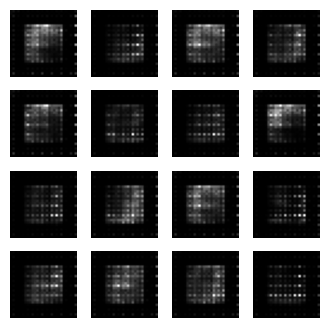

Epoch:  35
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 36 is 246.3460886478424 sec


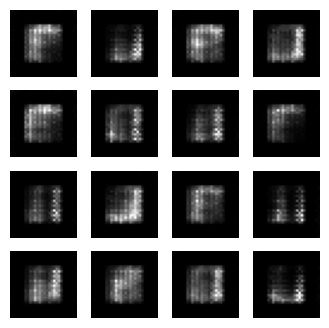

Epoch:  36
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 37 is 246.84056210517883 sec


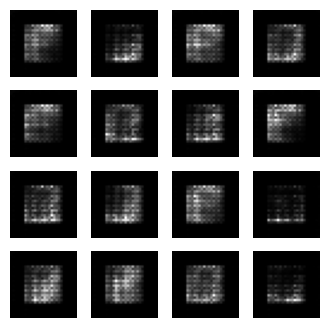

Epoch:  37
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 38 is 248.03498029708862 sec


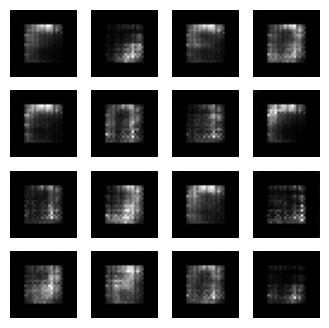

Epoch:  38
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 39 is 247.5532946586609 sec


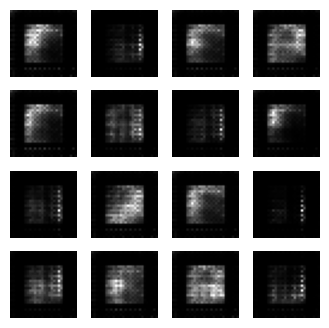

Epoch:  39
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 40 is 247.1416883468628 sec


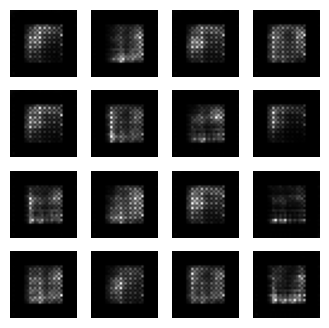

Epoch:  40
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 41 is 247.1749210357666 sec


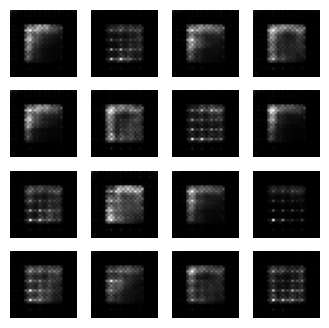

Epoch:  41
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 42 is 246.7561252117157 sec


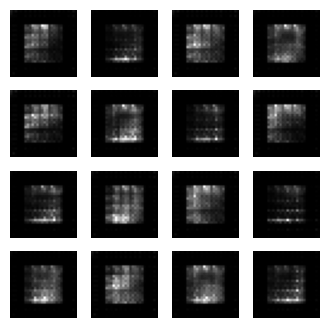

Epoch:  42
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 43 is 246.60671877861023 sec


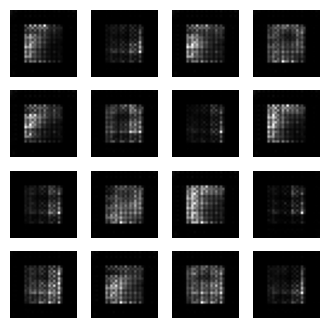

Epoch:  43
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 44 is 246.87376427650452 sec


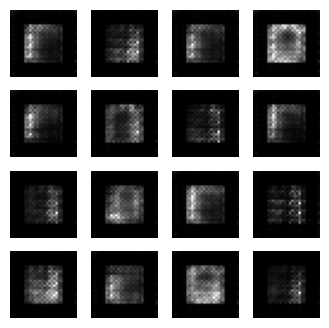

Epoch:  44
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 45 is 248.36753821372986 sec


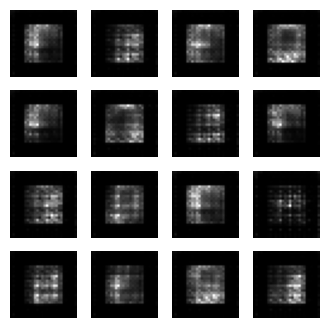

Epoch:  45
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 46 is 248.85840153694153 sec


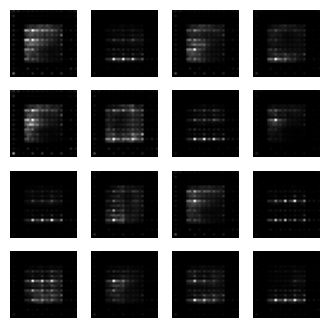

Epoch:  46
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 47 is 247.42738127708435 sec


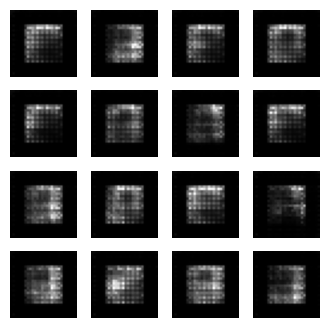

Epoch:  47
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 48 is 247.69313168525696 sec


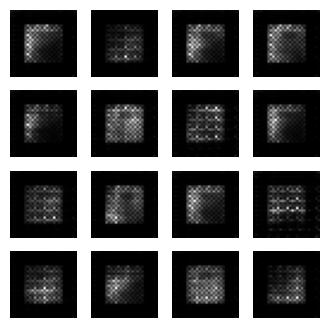

Epoch:  48
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 49 is 247.77606201171875 sec


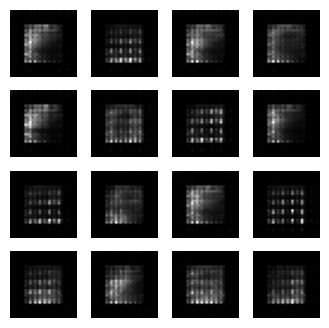

Epoch:  49
Batch: 100/528
Batch: 200/528
Batch: 300/528
Batch: 400/528
Batch: 500/528
Time for epoch 50 is 247.6516990661621 sec


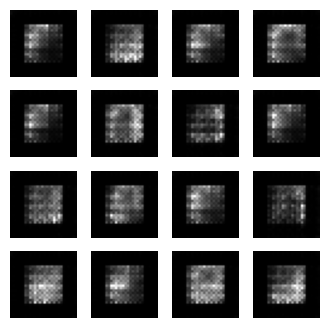

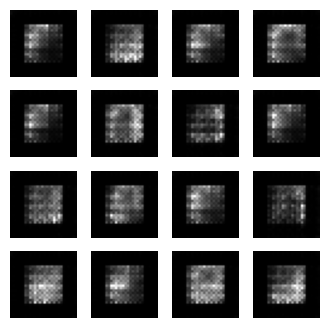

In [36]:
train(train_dataset, EPOCHS)

In [73]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## save the model
generator.save('generator.keras')
discriminator.save('discriminator.keras')
# gan.save('gan.keras')

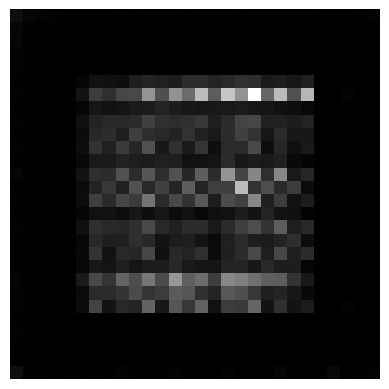

tf.Tensor([[-0.00983873]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.0115352]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.01000825]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00835034]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00849345]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00902157]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00906949]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00864671]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.01072051]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00880332]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.00782888]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00596322]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0049593]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00474489]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00129432]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00408726]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00141369]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00200566]], shape=(1, 1), dtype=float32)
t

In [78]:
## test the model
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

## test the discriminator
decision = discriminator(generated_image)
print (decision)

## generate 1000 images
num_images = 10
noise = tf.random.normal([num_images, 100])
generated_images = generator(noise, training=False)
for img in generated_images:
    decision = discriminator(tf.expand_dims(img, axis=0))
    print(decision)

## test positive image
test_images = train_images[:num_images]
for img in test_images:
    decision = discriminator(tf.expand_dims(img, axis=0))
    print(decision)




In [79]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))